# Reproduction for "Driver Identiﬁcation Based on Vehicle Telematics Data using LSTM-Recurrent Neural Network"

Authors:  
Daniel Cisneros Acevedo (4657349)  
Emre Ünlü (5404290)  
Stijn Waltmann (4548035) 

The goal of this blog is to reproduce the paper [Driver Identification Based on Vehicle Telematics Data using LSTM-Recurrent Neural Network](https://arxiv.org/abs/1911.08030). This paper uses vehicle telematics data (OBD-II) with machine learning tools to classify the driving style of a driver. The proposed model is a Long-Short Term Memory (LSTMs), this is an RNN architectures variant. For this reproduction, our group is assigned to reproduce Figures 9 & 10. These figures compare the accuracy of LTSMs against FCNN, Decision tree, and Random Forest models by inducing increasing levels of noise on the test data. We have chosen to do a mix of reproducing a small portion of the code and using some of the criteria given on Brightspace.

<figure>
  <img src="original_figure9.png" ref="Figure 9" width="400">
  <img src="original_figure10.png" ref="Figure 9" width="480">
  <figcaption>Figure 9 & 10</figcaption>
</figure>

## Inspecting the code

First look at the code it seems a bit messy, with multiple imports and multiple functions defined throughout the code. When running the code we seem to have trouble with X_test_5. Also, the author of the paper mentioned the code could have some issues because it was developed in a different setting.

We have copied several functions from the author's main code to our code main_functions.py and added docstrings for further clarification

## Data

There are three datasets from which one is of importance to us. That is the security driving dataset, collected by KIA Motors Corporation car in an uncontrolled environment. This is the only relevant dataset for this reproduction because figures 9 & 10 only contain these data points.

In [121]:
%load_ext autoreload
%autoreload 2

# import packages
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')
import os
import tensorflow as tf
from tensorflow.python.client import device_lib
from keras.models import load_model
from sklearn.preprocessing import StandardScaler

# import functions from main.py
from main_functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The data from the Security Driving Dataset is shown below below. There are 94380 datapoints and 54 columns. The "Class" represents the driver_id.
It's not a bad idea to look at the data distribution of the classes as class imbalance may affect model performance. Note, there are a total of 10 classes, or drivers in this case.

In [122]:
# read data
df = pd.read_csv('./Data/korea_vehicledata.csv')
df

,Time(s),Class,PathOrder,Fuel_consumption,Accelerator_Pedal_value,Throttle_position_signal,Short_Term_Fuel_Trim_Bank1,Intake_air_pressure,Filtered_Accelerator_Pedal_value,Absolute_throttle_position,...,Converter_clutch,Gear_Selection,Vehicle_speed,Acceleration_speed_-_Longitudinal,Indication_of_brake_switch_ON/OFF,Master_cylinder_pressure,Calculated_road_gradient,Acceleration_speed_-_Lateral,Steering_wheel_speed,Steering_wheel_angle
0,1,A,1,268.8,0.0,5.2,0.0,33,0,13.3,...,0,0,0,-8.5,1,325.5,0.0,-8.8,0,-3.4
1,2,A,1,243.2,0.0,6.1,0.0,40,0,13.7,...,0,0,0,0.1,1,0.9,0.0,-0.2,0,-3.6
2,3,A,1,217.6,0.0,5.2,0.0,41,0,13.7,...,0,0,0,0.1,1,0.9,0.0,-0.2,0,-3.6
3,4,A,1,204.8,0.0,4.7,0.0,38,0,13.3,...,0,0,0,0.1,1,0.9,0.0,-0.2,0,-3.6
4,5,A,1,217.6,0.0,5.7,0.0,40,0,13.7,...,0,0,0,0.1,1,0.9,0.0,-0.2,0,-3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94375,2564,D,2,345.6,0.0,6.6,7.0,0,0,14.5,...,0,7,0,-0.2,2,2.3,0.0,0.0,0,-13.2
94376,2565,D,2,345.6,0.0,6.6,7.0,0,0,14.5,...,0,7,0,0.1,2,8.7,0.0,-0.1,0,-13.0
94377,2566,D,2,345.6,0.0,6.6,7.0,0,0,14.5,...,0,0,0,-0.2,2,12.6,0.0,0.0,0,-13.2
94378,2567,D,2,332.8,0.0,5.7,6.3,0,0,14.1,...,0,0,0,-0.2,2,13.0,0.0,0.0,0,-13.3


Class D and B have the highest number of datapoints


Text(0.5, 0, 'Classes')

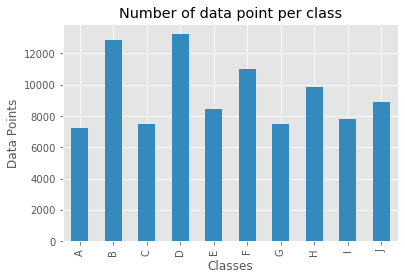

In [123]:
# data distribution per class

print('Class D and B have the highest number of datapoints')

df['Class'].value_counts().sort_index().plot(kind='bar', title='Number of data point per class',color='C1')
plt.ylabel('Data Points')
plt.xlabel('Classes')

## Model Architecture

The architecture of the deep LTSM model is a two hidden layer network with 160 neurons in the first hidden layer and 200 neurons in the second hidden layer. 

Fortunately, the authors provided us with their model which we can use as inspiration to start off our search!

The model .config() can be commented out for more information on the exact settings. For example, we can find out which dropout rate the authors used.

In [124]:
author_model = load_model('Model_clean_binary_cross_ICTAI_vehicle2_1')
author_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, None, 160)         116480    
                                                                 
 batch_normalization_3 (Batc  (None, None, 160)        640       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, None, 160)         0         
                                                                 
 lstm_4 (LSTM)               (None, 120)               134880    
                                                                 
 batch_normalization_4 (Batc  (None, 120)              480       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 120)              

In [125]:
# comment out this line to obtain model setup
# author_model.get_config()

## Fitting Data

The original idea was to use the criteria mentioned on Brightspace however, the code didn't fully run therefore we created our own model so we could run it. Next to this, we will also apply a hyperparameter check and ablation study.

### Preprocessing

In [184]:
# prepare features and classes
X, y = pre_process_encoder(df)

In [185]:
# partition the data with windows and assign it to train or test
X_train, y_train, X_test,y_test = rnn_dimension(X,y)

In [186]:
# normalize the data (very important)
X_train_scaled = normalizing(X_train)
X_test_scaled = normalizing(X_test)


### Hyperparameter
Right now, the overall context of the data is pretty clear. It's time to start building models and fitting it to the data. 

The build_model() function is used to do hyperparameter checking. We'll also use keras tuner to automatically search for the best model.

In [182]:
# import keras packages
from keras.layers import Dense, Dropout, LSTM, Activation, Flatten
from keras_tuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

# import other packages

# build_model is a function that is defined underneath here right?
# import build_model 
import pathlib
from keras import callbacks


In [187]:
# create validation set for hyperparameter checking
X_val, X_test, y_val, y_test = train_test_split(X_test_scaled, y_test, test_size=0.7, random_state=1)




(1770, 10)
(1239, 10)


In [178]:
print(X_val.shape, X_test.shape, y_val.shape, y_test.shape)

print(X_test_scaled.shape, y_test.shape)

(531, 16, 53) (1239, 16, 53) (531, 10) (1239, 10)
(1770, 16, 53) (1239, 10)


In [131]:
# instantiate hyperparameter object
# this will be passed to the build_model() function
hp = HyperParameters()

In [132]:
# build model
def build_model(hp):
    """ 
    Build model for dynamic hyper parameter training.
    input: hp "object" (HyperParameters() from kerastuner.engine.hyperparameters)
    """
    
    # Create sequential model
    model = Sequential()

    # HyperParameters
    activations = hp.Choice("activation", ["relu", "tanh"])
    dropouts    = hp.Float("dropout", min_value=0.3, max_value=0.6, step=0.05)
    optimizers  = hp.Choice("optimizer", ["adam", "sgd"])
    units       = hp.Int("units", min_value=140, max_value=220, step=10)

    # first LSTM layer
    model.add(LSTM(
        units=units, 
        input_dim=X_train.shape[2], 
        activation=activations, 
        return_sequences=True))

    # intermediate layers
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropouts))

    # 2nd LSTM layer
    model.add(LSTM(
        units=units, 
        input_shape=(X_train.shape[1],X_train.shape[2]), 
        activation= activations, 
        return_sequences=False))

    # intermediate layers
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropouts))

    # output layer
    model.add(Dense(y_train.shape[1], activation='softmax'))

    # compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizers, metrics=['accuracy'])

    return model

In [133]:
weight_history = []
bias_history = []
class MyCallback(callbacks.Callback):
    def on_batch_end(self, batch, logs):
        weight, bias = model.get_weights()
        B = bias[0]
        W = weight[0][0]
        weight_history.append(W)
        bias_history.append(B)
callback = MyCallback()

In [134]:
csv_logger = callbacks.CSVLogger('training.csv', append=True)

In [135]:
# specify path to save the search
path_save = pathlib.Path(str(pathlib.Path().parent.resolve()) + "/models")

# change project name
project_name = "search1"

tuner = RandomSearch(
    build_model,
    objective = "val_accuracy",
    max_trials = 2,
    executions_per_trial = 1,
    directory = path_save,
    project_name= project_name,
    overwrite = True
)



In [136]:
tuner.search(x=X_train_scaled, 
             y=y_train,
             epochs=2, 
             batch_size=21, 
             validation_data=(X_val, y_val),
            #  callbacks=[tf.keras.callbacks.TensorBoard(pathlib.Path(r'C:\Users\dicis\Desktop\models'))]
             callbacks=[csv_logger]
            )

Trial 2 Complete [00h 01m 14s]
val_accuracy: 0.7589454054832458

Best val_accuracy So Far: 0.8286252617835999
Total elapsed time: 00h 02m 19s
INFO:tensorflow:Oracle triggered exit


In [137]:
tuner.get_best_models(num_models=5)

In [138]:
pd.read_json('./models/search1/trial_0/trial.json')

,trial_id,hyperparameters,metrics,score,best_step,status
space,0,"[{'class_name': 'Choice', 'config': {'name': '...",NaN,0.828625,0,COMPLETED
values,0,"{'activation': 'tanh', 'dropout': 0.4499999999...",NaN,0.828625,0,COMPLETED
metrics,0,NaN,"{'loss': {'direction': 'min', 'observations': ...",0.828625,0,COMPLETED


In [139]:
pd.read_json('./models/search1/trial_0/trial.json')['hyperparameters'][1]

{'activation': 'tanh',
 'dropout': 0.449999999999999,
 'optimizer': 'adam',
 'units': 190}

In [140]:
pd.read_json('./models/search1/trial_0/trial.json')['metrics'][-1]

{'loss': {'direction': 'min',
  'observations': [{'value': [0.6749832630157471], 'step': 0}]},
 'accuracy': {'direction': 'max',
  'observations': [{'value': [0.7601236701011651], 'step': 0}]},
 'val_loss': {'direction': 'min',
  'observations': [{'value': [0.46067184209823603], 'step': 0}]},
 'val_accuracy': {'direction': 'max',
  'observations': [{'value': [0.8286252617835991], 'step': 0}]}}

In [141]:
tuner.trials

AttributeError: 'RandomSearch' object has no attribute 'trials'

In [143]:
a_model = tuner.get_best_models(num_models=5)[3]

IndexError: list index out of range

In [144]:
best_model = tuner.get_best_models(num_models=1)[0]

In [145]:
best_model.fit(X_train_scaled, y_train, epochs=6, batch_size=21, shuffle=False)

Epoch 1/6
478/478 [==============================] - 32s 56ms/step - loss: 0.5159 - accuracy: 0.8188
Epoch 2/6
478/478 [==============================] - 29s 60ms/step - loss: 0.4037 - accuracy: 0.8601
Epoch 3/6
478/478 [==============================] - 30s 63ms/step - loss: 0.3602 - accuracy: 0.8776
Epoch 4/6
478/478 [==============================] - 29s 61ms/step - loss: 0.2780 - accuracy: 0.9080
Epoch 5/6
478/478 [==============================] - 29s 61ms/step - loss: 0.2438 - accuracy: 0.9211
Epoch 6/6
478/478 [==============================] - 29s 60ms/step - loss: 0.2164 - accuracy: 0.9286


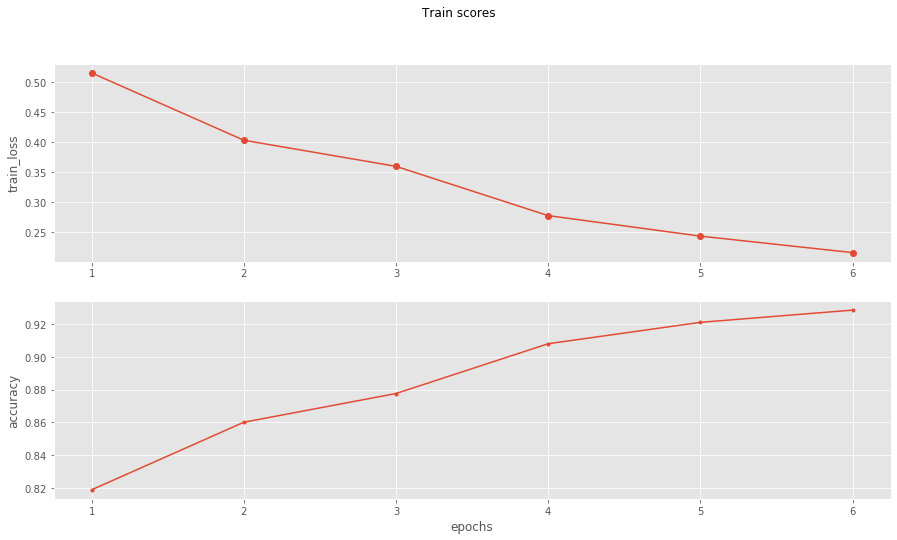

In [146]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

epochs = np.arange(1, len(best_model.history.history['loss']) + 1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
fig.suptitle('Train scores')

ax1.plot(epochs, best_model.history.history['loss'], 'o-')
ax1.set_ylabel('train_loss')

ax2.plot(epochs, best_model.history.history['accuracy'], '.-')
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')

plt.show()

In [147]:
best_model.save('./best_model')

2022-04-05 18:05:31.429335: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./best_model/assets


INFO:tensorflow:Assets written to: ./best_model/assets


In [148]:
LSTM_model = load_model('./best_model')

## Reproducing fig 9
We are starting with reproducing figure 9, taken from the original paper:

<img src="original_figure9.png" alt="Graph showing 4 different classfiers' robustness to noise. LSTM is clearly the most robust" style="width: 500px;"/>

To do this, we first need the 4 different models shown (LSTM, FCNN, DecisionTree, RandomForest) in the graph. We use the LSTM that we found through the hyper parameter tuning above. The design of the FCNN that was likely used for this graph can be found in the code provided by the original author. The DecisionTree and RandomForest can be imported straight from keras. 

To start, we prepare the data again. This is done to keep everythhing contained a bit, and not use data that was prepared in a different part of the code. We load the data, one hot encode the labels and create train/test sets. Lastly, we scale the training and testing inputs. We do not apply the window function on this data, as the LSTM is the only one that takes windows as input.

In [149]:
# Get a clean copy of the data to make sure previous cells did not do something unexpected to the data
# As in the original paper, these model will be trained on the data without 'windows' (ie group of consecutive data points)
# This data will be marked as _nw (No Window) I do agree the names are getting a little long

df = pd.read_csv('./Data/korea_vehicledata.csv')
X_nw, y_nw = pre_process_encoder(df)

encoder = LabelEncoder()
encoder.fit(y_nw)
y_ints = encoder.transform(y_nw)  # A, B, C, ... --> 1, 2, 3, ...
y_dummy_nw = np_utils.to_categorical(y_ints)  # 2 --> [0, 0, 1, 0, ..., 0]
X_train_nw, X_test_nw, y_train_nw, y_test_nw =train_test_split(X_nw, y_dummy_nw, train_size=0.85)
X_train_scaled_nw = normalizing_2d(X_train_nw)
X_test_scaled_nw = normalizing_2d(X_test_nw)


The below cell shows the difference between the data. The numbers are the same, just the way they are presented is different.

In [150]:
print(f"The data with windows has shape {X_train_scaled.shape}")
print(f"The data without windows has shape {X_train_scaled_nw.shape}")

The data with windows has shape (10026, 16, 53)
The data without windows has shape (80223, 53)


We import the layers we need (some were already imported but for me it is nice to be able to run just this part - hence I import them again).
We also import some functions and classifiers from sklearn.

In [151]:
from keras.layers import Flatten, Dense
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

We start by creating the FCNN, by adapting (but mainly copying) the code from the author and fitting it on the training data.

In [152]:
FCNN_model = Sequential()
# FCNN_model.add(Flatten())  # Flatten the input data so it can be passed through the dense layer
FCNN_model.add(Dense(160, input_dim=X_train_scaled_nw.shape[1], activation='relu'))
FCNN_model.add(layers.BatchNormalization())
FCNN_model.add(layers.Dropout(0.5))
FCNN_model.add(Dense(120, activation='relu'))
FCNN_model.add(layers.BatchNormalization())
FCNN_model.add(Dense(y_test_nw.shape[1], activation='softmax'))
# FCNN_model.add(Dense(1,activation='sigmoid'))
# FCNN_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
FCNN_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
with tf.device('/GPU:0'):
    FCNN_history = FCNN_model.fit(X_train_scaled_nw, y_train_nw, epochs=10,batch_size=100, shuffle=True)

Epoch 1/10
803/803 [==============================] - 4s 4ms/step - loss: 1.2477 - accuracy: 0.5505
Epoch 2/10
803/803 [==============================] - 3s 4ms/step - loss: 0.6529 - accuracy: 0.7574
Epoch 3/10
803/803 [==============================] - 4s 5ms/step - loss: 0.4796 - accuracy: 0.8244
Epoch 4/10
803/803 [==============================] - 4s 5ms/step - loss: 0.4001 - accuracy: 0.8544
Epoch 5/10
803/803 [==============================] - 4s 5ms/step - loss: 0.3541 - accuracy: 0.8694
Epoch 6/10
803/803 [==============================] - 4s 4ms/step - loss: 0.3175 - accuracy: 0.8836
Epoch 7/10
803/803 [==============================] - 3s 4ms/step - loss: 0.2916 - accuracy: 0.8946
Epoch 8/10
803/803 [==============================] - 3s 4ms/step - loss: 0.2705 - accuracy: 0.9021
Epoch 9/10
803/803 [==============================] - 4s 5ms/step - loss: 0.2540 - accuracy: 0.9077
Epoch 10/10
803/803 [==============================] - 3s 4ms/step - loss: 0.2363 - accuracy: 0.9148

We create a function to get the accuracy: it un-one-hot-encodes the predicted and true labels, and then get the accuracy. This will help to show if the DecisionTree and RandomForest are working as they should.

In [153]:
def test_accuracy(model, X, y):
    y_predict = model.predict(X)
    y_pred=np.argmax(y_predict, axis=1)
    y_test=np.argmax(y, axis=1)
    return metrics.accuracy_score(y_test, y_pred)

We now create a DecisionTree and RandomForest classifier. We also get their accuracies on both the test and training data to see if they are over or underfitting.

In [154]:
# Both the tree and forest are trained on the data WITHOUT windows
# Accuracy is higer that way then when training on data with windows (which is then reshaped)

print("### DecisionTree ###\n")
DT_model = DecisionTreeClassifier()
DT_model.fit(X_train_scaled_nw, y_train_nw)

print("Training data accuracy:")
print(test_accuracy(DT_model, X_train_scaled_nw, y_train_nw))

print("Test accuracy:")
print(test_accuracy(DT_model, X_test_scaled_nw, y_test_nw))

print("\n### RandomForest ###\n")
RF_model = RandomForestClassifier(n_estimators=50)  # original paper uses 20 estimators
RF_model.fit(X_train_scaled_nw, y_train_nw)

print("Training data accuracy:")
print(test_accuracy(RF_model, X_train_scaled_nw, y_train_nw))

print("Test accuracy:")
print(test_accuracy(RF_model, X_test_scaled_nw, y_test_nw))


### DecisionTree ###

Training data accuracy:
1.0
Test accuracy:
0.9886275340820795

### RandomForest ###

Training data accuracy:
1.0
Test accuracy:
0.9795154340608886


We now have the four models, but the LSTM and FCNN are not very well trained yet. Their accuracy is around 90% while the paper is closer to 100%. To fix this, we let them train for a bit longer. I suggest not to use this and just load the model:)

In [155]:
using_saved_model = True

if using_saved_model:
    FCNN_model = load_model('./FCNN_model_reproduce')
    LSTM_model = load_model('./LSTM_model_reproduce')
else:  # fit the models
    with tf.device('/GPU:0'):
        FCNN_history = FCNN_model.fit(X_train_scaled_nw, y_train_nw, epochs=150,batch_size=100, shuffle=True)
        FCNN_model.save('./FCNN_model_reproduce')
        # Make sure to train LSTM on 'windowed' data
        LSTM_history = LSTM_model.fit(X_train_scaled, y_train, epochs=150, batch_size=21, shuffle=False)
        LSTM_model.save('./LSTM_model_reproduce')


For a quick overview: these are the models' performance on the data without any noise

In [188]:
print(f"FCNN accuracy is {test_accuracy(FCNN_model, X_test_scaled_nw, y_test_nw)}")
print(f"LSTM accuracy is {test_accuracy(LSTM_model, X_test, y_test)}")
print(f"DecisionTree accuracy is {test_accuracy(DT_model, X_test_scaled_nw, y_test_nw)}")
print(f"RandomForest accuracy is {test_accuracy(RF_model, X_test_scaled_nw, y_test_nw)}")

    

FCNN accuracy is 0.9978809069718161
LSTM accuracy is 0.9967715899919289
DecisionTree accuracy is 0.9886275340820795
RandomForest accuracy is 0.9795154340608886


Now that all models exist, we can start adding noise to the test data. To do this, we create function that takes NORMALIZED data and a standard deviation for the nosie and returns the data with added noise.

In [207]:
def add_noise(data, sigma):        
    size_ = data.shape
    noise = np.random.normal(0, sigma, size=size_) # 1000 samples with normal distribution
    return data+noise

To show that the function works, we print the difference between some data before and after the noise function.

In [212]:
print((add_noise(X_train_scaled_nw, 1) - X_train_scaled_nw)[0])

[ 0.55924832  0.04291894 -0.36959845 -0.34278644  0.20866268  1.26849472
  1.42689347  0.37006424 -0.06776496  0.82578912 -0.02167289  0.34891083
 -0.54919848  0.34386349  2.93019672 -0.72937685 -1.53549348 -0.82782815
 -0.85098607  1.97075733 -0.42914093 -1.40071621  1.71183735  0.29083602
  1.79681858  1.47431209 -0.46752307 -1.49306232 -1.21859955  1.08764029
 -0.23774315 -1.02384847  1.69189037 -1.06685276  0.305674   -0.522591
  0.60381715 -0.65579526 -0.34311842  0.55643082  0.02044878 -1.37585579
 -0.15046398 -1.36228113 -0.69238158 -0.40313119  0.67425629  0.13798781
  0.72775728 -0.82437803 -0.39613622  0.07120739  0.24741746]


We can now loop through increasing amounts of noise and get the accuracy for each noisy data.

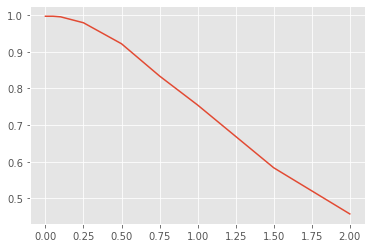

In [219]:
standard_deviation = [0, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 1.5, 2]
accuracy = []

for sigma in standard_deviation:
    X_noisy = add_noise(X_test, sigma)
    accuracy.append(test_accuracy(LSTM_model, X_noisy, y_test))

plt.plot(standard_deviation, accuracy)

We can put this in a function, and call it for each model.

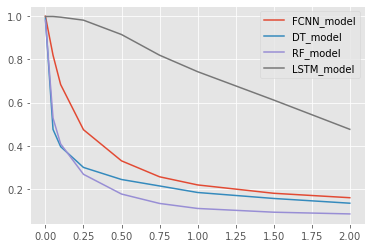

In [225]:
def noise_robustness(model, X, y, standard_deviations):
    accuracies = []

    for sigma in standard_deviations:
        X_noisy = add_noise(X, sigma)
        accuracies.append(test_accuracy(model, X_noisy, y))

    return standard_deviations, accuracies


standard_deviation = [0, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 1.5, 2]

# These models use the same training data, so they can be called in a loop:
for model, label in zip([FCNN_model, DT_model, RF_model], ["FCNN_model", "DT_model", "RF_model"]):
    plot_data = noise_robustness(model, X_test_scaled_nw, y_test_nw, standard_deviation)
    plt.plot(plot_data[0], plot_data[1], label=label)

plot_data = noise_robustness(LSTM_model, X_test, y_test, standard_deviation)
plt.plot(plot_data[0], plot_data[1], label="LSTM_model")

plt.legend()
plt.show()

